In [2]:
# Test migration history reconstruction on simulated data

import sys
import os

REPO_DIR = os.path.join(os.getcwd(), "../../../")
from metient.metient import *
import metient.util.vertex_labeling_util as vutil
import metient.util.data_extraction_util as dutil

import matplotlib
import torch
MACHINA_DATA_DIR = os.path.join(REPO_DIR, 'metient/data/machina_sims')
OUT_DIR = os.path.join(REPO_DIR, "metient/test/output_plots")

CUDA GPU: False


In [3]:
import pydot
from IPython.display import Image, display

def visualize_ground_truth(tree_fn, graph_fn):
    def view_pydot(pdot):
        plt = Image(pdot.create_png())
        display(plt)
    
    (graph,) = pydot.graph_from_dot_file(tree_fn)
    view_pydot(graph)

    (graph,) = pydot.graph_from_dot_file(graph_fn)
    view_pydot(graph)
        

Ground truth


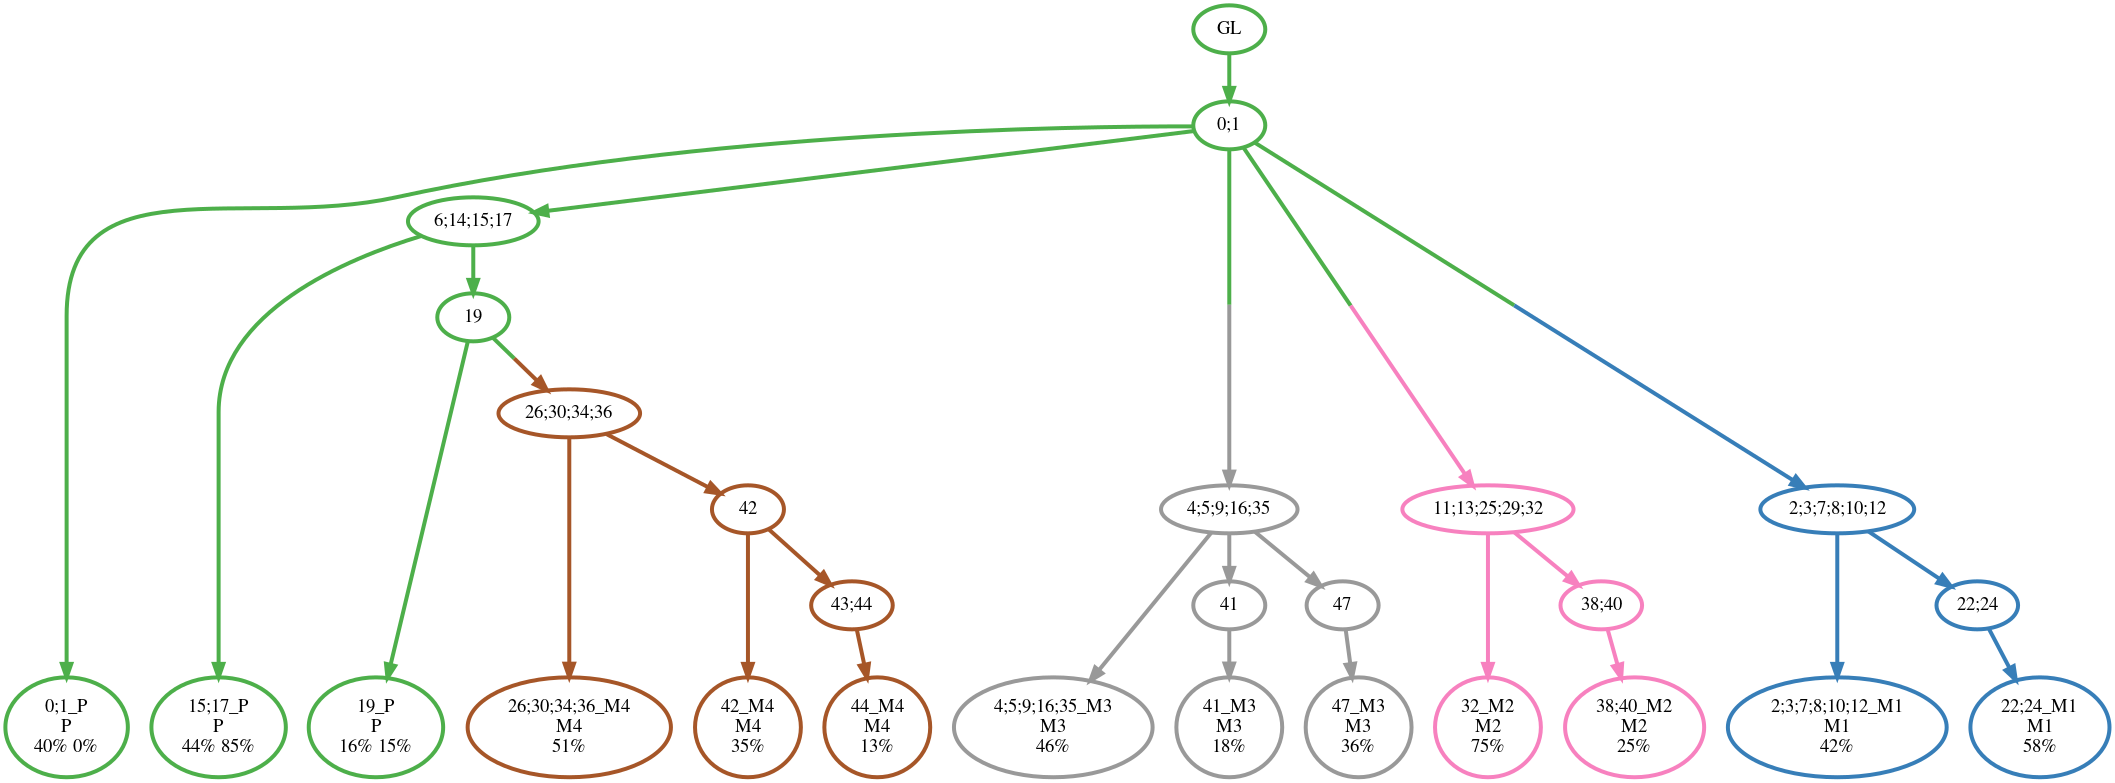

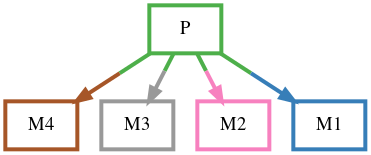

In [4]:
num_sites = "m5"
mig_type = "mS"
seed = 5

og_sims_dir = "/data/morrisq/divyak/projects/machina/data/sims"
SIM_DATA_DIR = os.path.join(og_sims_dir, num_sites, mig_type)
print("Ground truth")
visualize_ground_truth(os.path.join(SIM_DATA_DIR, f"T_seed{seed}.dot"), os.path.join(SIM_DATA_DIR, f"G_seed{seed}.dot"))

In [5]:
import fnmatch
custom_colors = [matplotlib.colors.to_hex(c) for c in ['limegreen', 'cornflowerblue', 'hotpink', 'grey', 'saddlebrown', 'darkorange', 'purple', 'red', 'black', 'black', 'black', 'black']]
def find_labelings_all_mutation_trees(site, cluster_fn, all_mut_trees_fn, ref_var_fn):
    weights = Weights(mig=0.563*50, comig=0.246*50, seed_site=0.197*50,gen_dist=0.1, reg=0.5, data_fit=15.0)
    
    trees = fnmatch.filter(os.listdir(os.path.join(MACHINA_DATA_DIR, f"{site}_clustered_input_corrected")), f"cluster_{mig_type}_seed{seed}_tree*.tsv")

    idx_to_cluster_label = dutil.get_idx_to_cluster_label(cluster_fn)
    data = dutil.get_adj_matrices_from_spruce_mutation_trees(all_mut_trees_fn, idx_to_cluster_label, is_sim_data=True)
    custom_colors = [matplotlib.colors.to_hex(c) for c in ['limegreen', 'royalblue', 'hotpink', 'grey', 'saddlebrown', 'darkorange', 'purple', 'red', 'black', 'black', 'black', 'black']]
    perf_stats = []
    trees = trees[:3]

    print("Number of trees:", len(trees))
    for tree_num in range(len(trees)):

        ref_var_fn = os.path.join(MACHINA_DATA_DIR, f"{site}_clustered_input_corrected", f"cluster_{mig_type}_seed{seed}_tree{tree_num}.tsv")
        data = dutil.get_adj_matrices_from_spruce_mutation_trees(all_mut_trees_fn, idx_to_cluster_label, is_sim_data=True)
        T = torch.tensor(data[tree_num][0], dtype = torch.float32)
        print(T.shape)
        print_config = PrintConfig(visualize=True, verbose=True, k_best_trees=10, save_outputs=True)
#         vert.evaluate(T, ref_var_fn, weights, print_config, "../output_plots/", f"tree{tree_num}_seed{seed}", 
#                       None, batch_size=1024, custom_colors=custom_colors, bias_weights=True, solve_polytomies=True)
        calibrate([T], [ref_var_fn], print_config, "../output_plots/", [f"tree{tree_num}_seed{seed}"], 
                   None, batch_size=256, custom_colors=custom_colors, solve_polytomies=True)

        

Number of trees: 1
torch.Size([10, 10])
Saving results to ../output_plots/calibrate
Overwriting existing directory at ../output_plots/calibrate

*** Calibrating for patient: tree0_seed5 ***
ordered_sites ['P', 'M1', 'M2', 'M3', 'M4']


 10%|▉         | 43/450 [00:00<00:13, 30.47it/s]/lila/data/morrisq/divyak/projects/metient/metient/lib/v_optimizer.py:412: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3614.)
  known_labelings.append(torch.eye(v_solver.num_sites)[optimal_site].T)
100%|█████████▉| 449/450 [00:04<00:00, 113.62it/s]

Time elapsed: 5.695494
pareto_metrics {(4, 4, 1)}
# final solutions: 2
Saving tree0_seed5_P to ../output_plots/calibrate
tree0_seed5_P
10 unique trees were not found (2 were found). Retry with a higher sample size if you want to get more trees.


<Figure size 640x480 with 0 Axes>

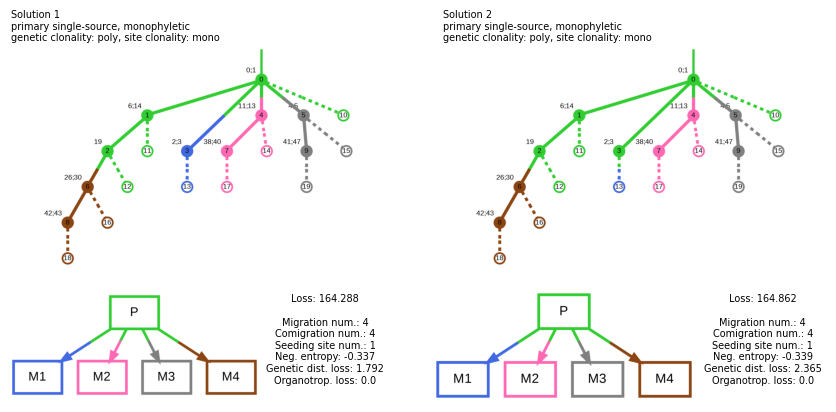

Saving tree0_seed5_P to ../output_plots/calibrate


100%|██████████| 450/450 [00:19<00:00, 113.62it/s]

In [6]:
# %%prun -D prof_output.prof
find_labelings_all_mutation_trees(num_sites, os.path.join(MACHINA_DATA_DIR, f"{num_sites}_clustered_input", f"cluster_{mig_type}_seed{seed}.txt"),
                                  os.path.join(MACHINA_DATA_DIR, f"{num_sites}_mut_trees", f"mut_trees_{mig_type}_seed{seed}.txt"),
                                  os.path.join(MACHINA_DATA_DIR, f"{num_sites}_clustered_input", f"cluster_{mig_type}_seed{seed}.tsv"))

In [6]:
import pstats

# Load the profiling data
p = pstats.Stats('prof_output.prof')

# Sort by cumulative time and print the top 20 functions
p.sort_stats('cumtime').print_stats(50)

Wed Jul 10 08:07:01 2024    prof_output.prof

         8854054 function calls (8791754 primitive calls) in 63.936 seconds

   Ordered by: cumulative time
   List reduced from 3113 to 50 due to restriction <50>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    634/1    0.029    0.000   63.939   63.939 {built-in method builtins.exec}
        1    0.000    0.000   63.939   63.939 /scratch/lsftmp/8015765.tmpdir/ipykernel_7082/4163800629.py:3(find_labelings_all_mutation_trees)
        3    0.001    0.000   63.909   21.303 /lila/data/morrisq/divyak/projects/metient/metient/metient.py:59(calibrate)
        3    0.002    0.001   63.908   21.303 /lila/data/morrisq/divyak/projects/metient/metient/lib/migration_history_inference.py:195(calibrate)
        3    0.018    0.006   55.217   18.406 /lila/data/morrisq/divyak/projects/metient/metient/lib/migration_history_inference.py:307(infer_migration_history)
        3    0.000    0.000   28.858    9.619 /lila/data/morrisq/d

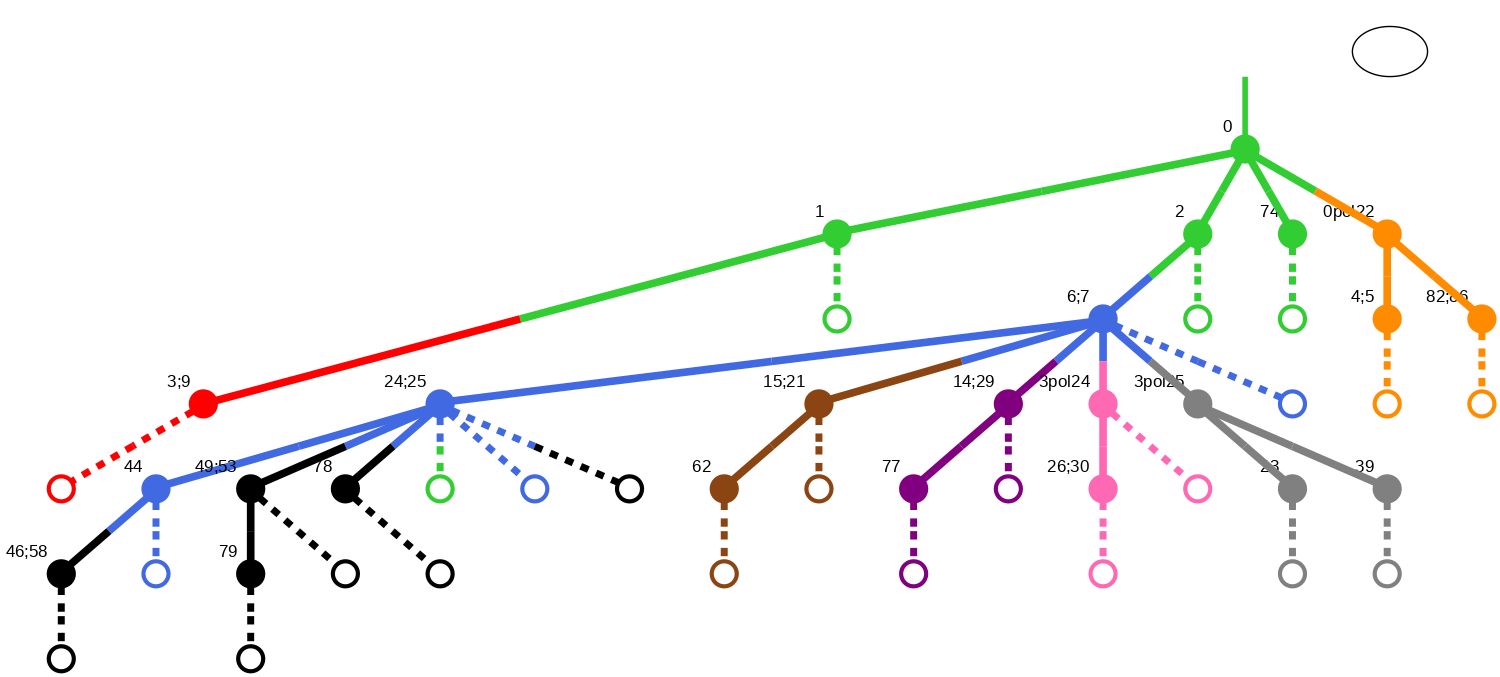

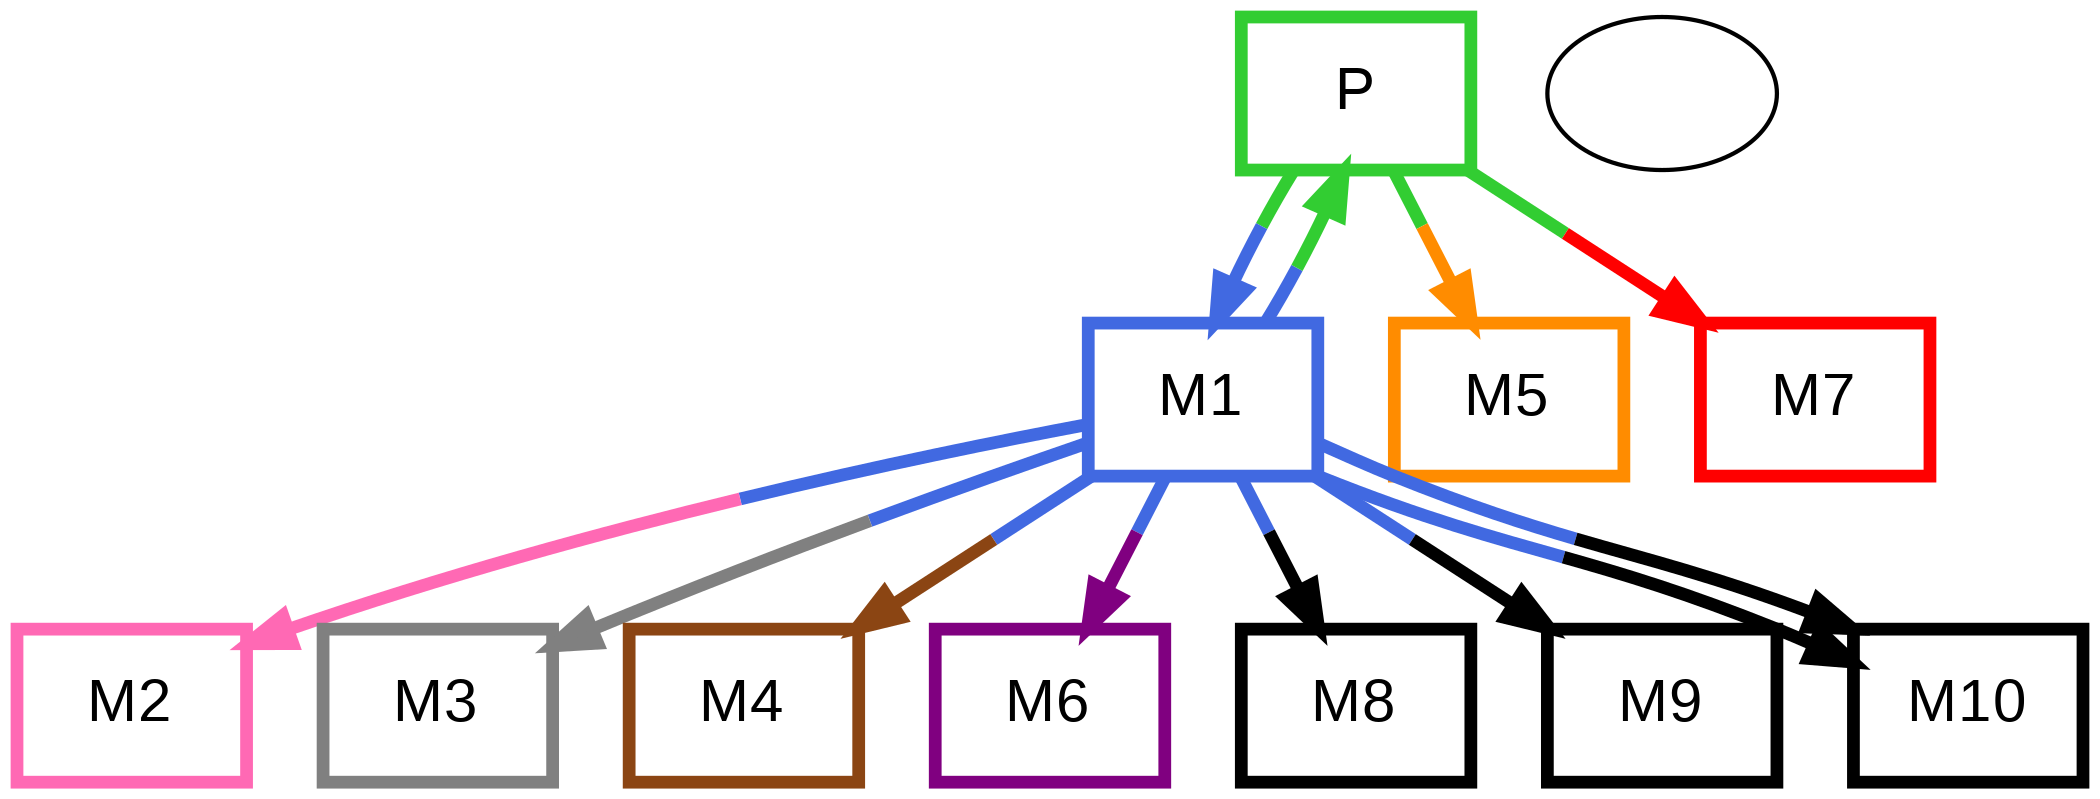

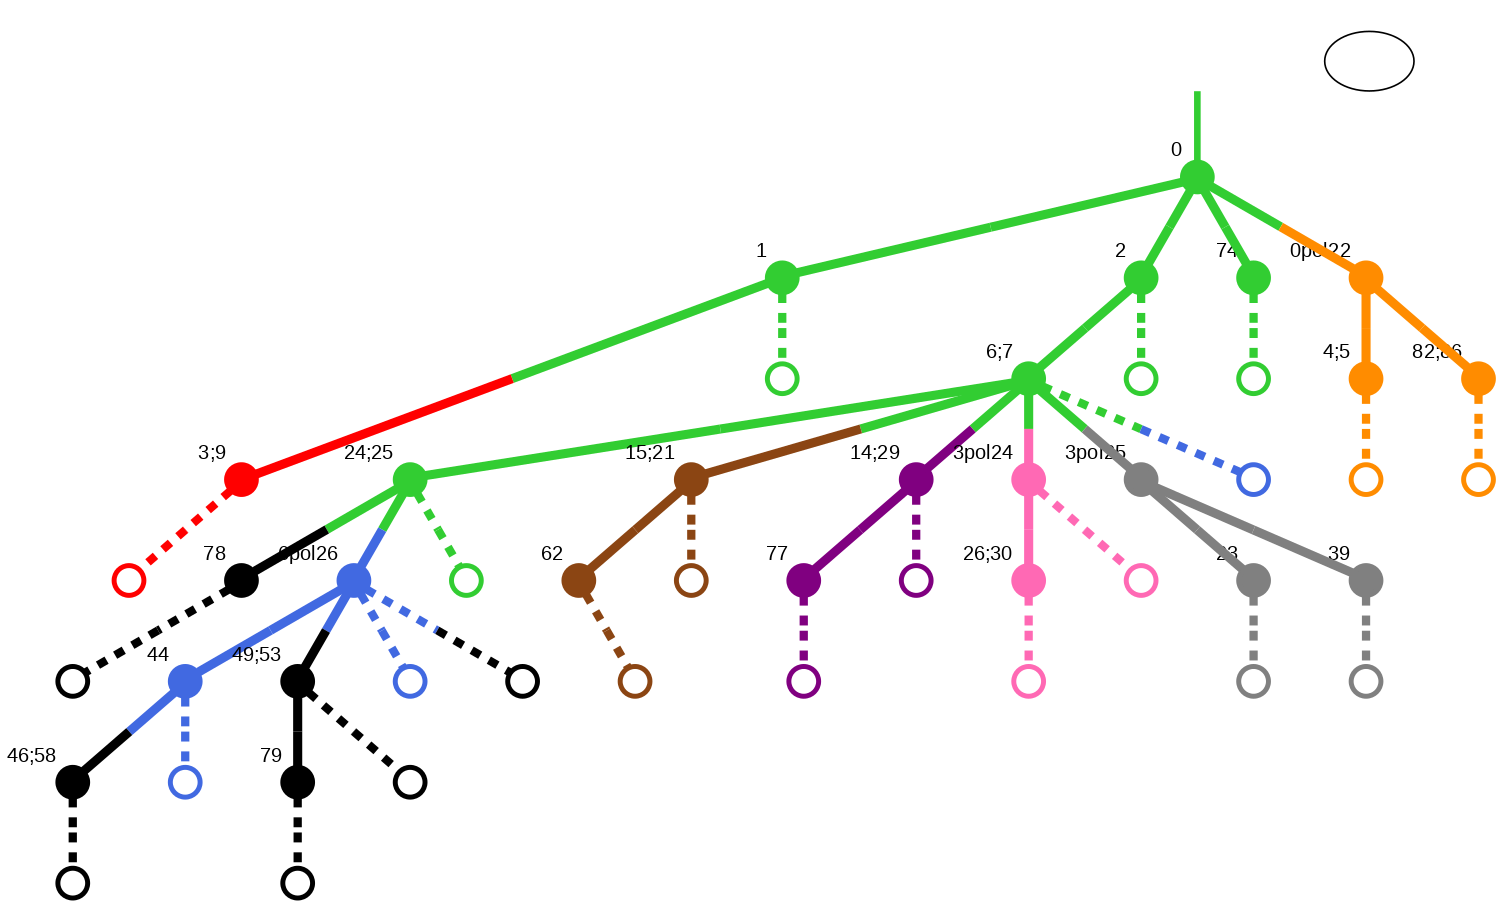

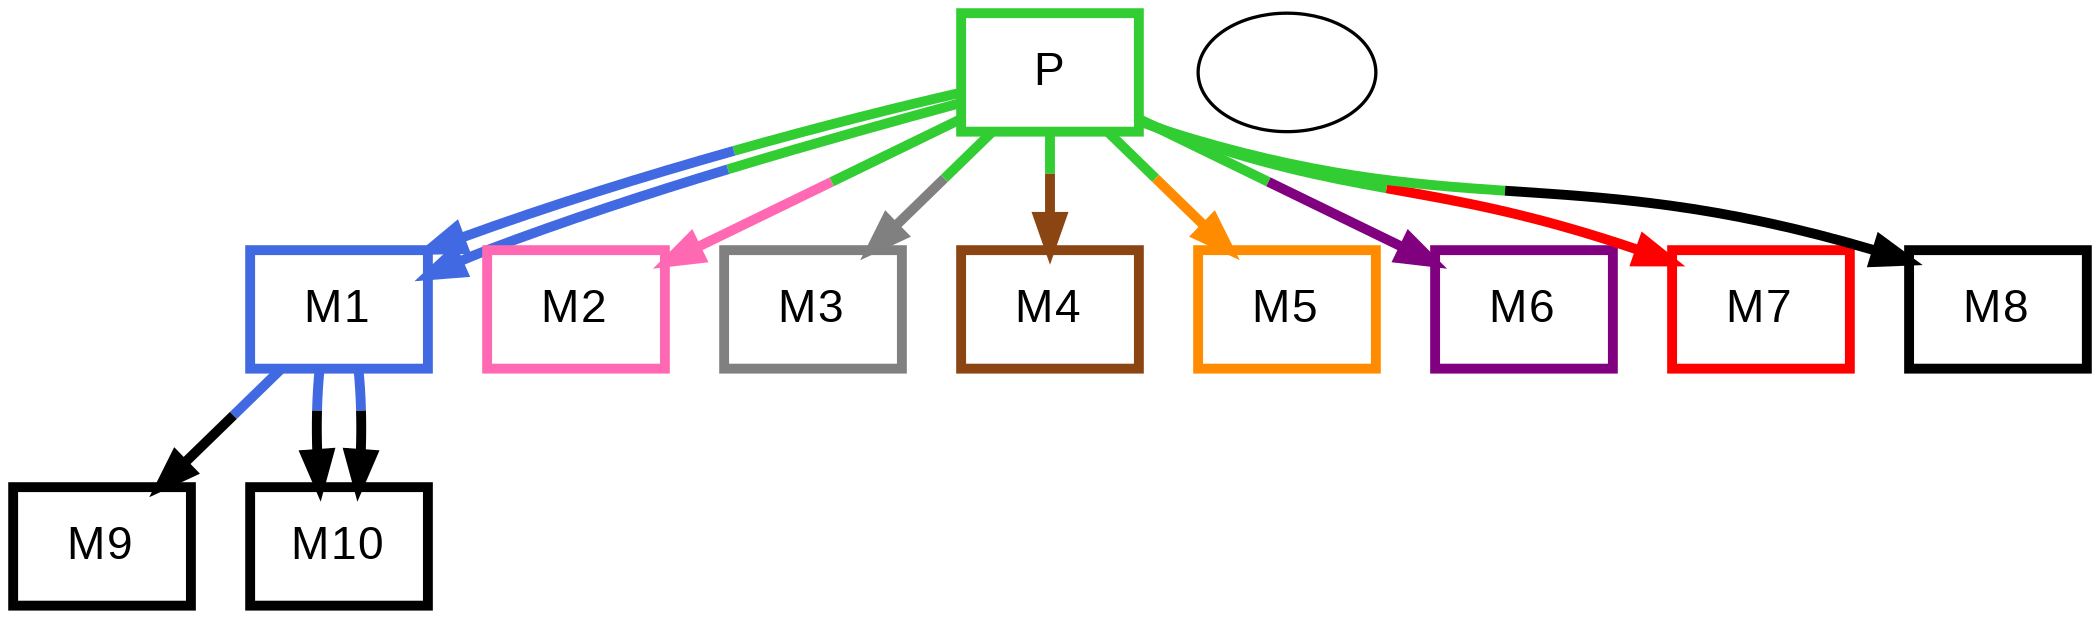

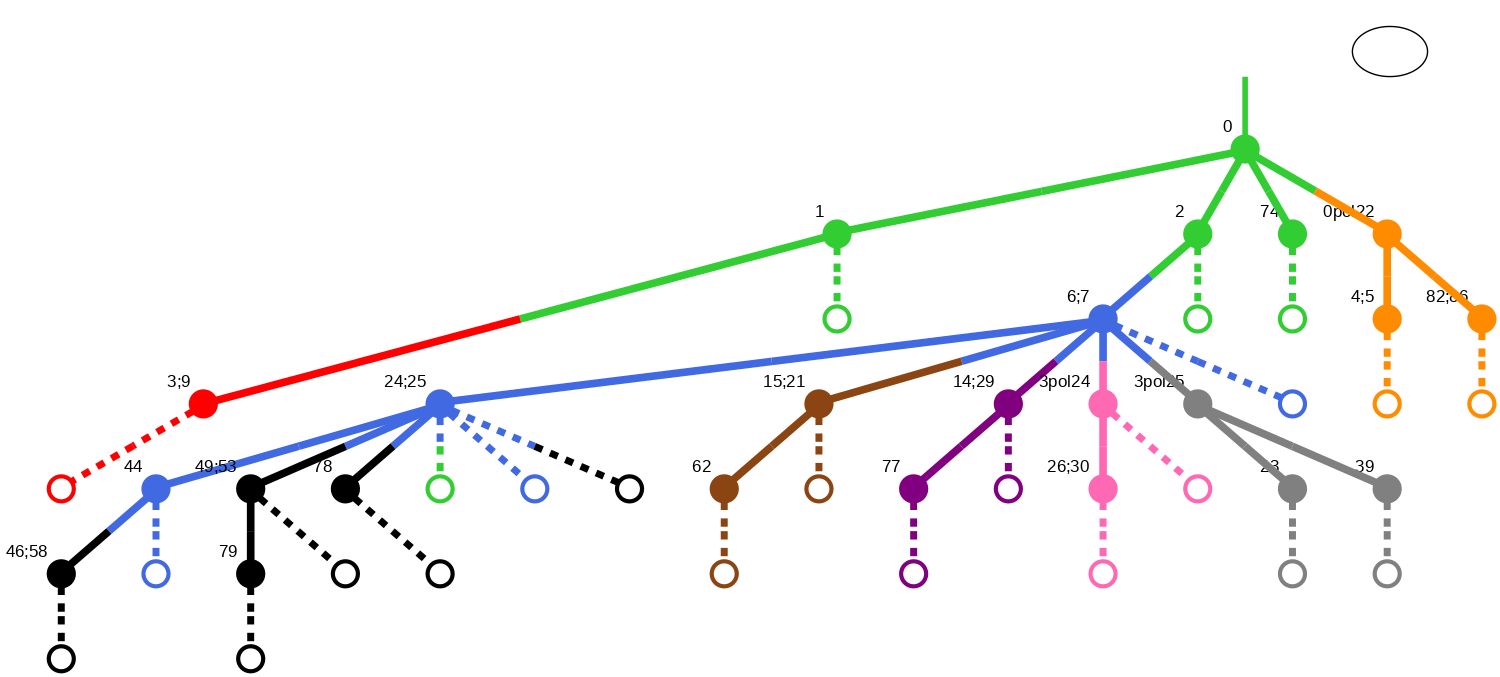

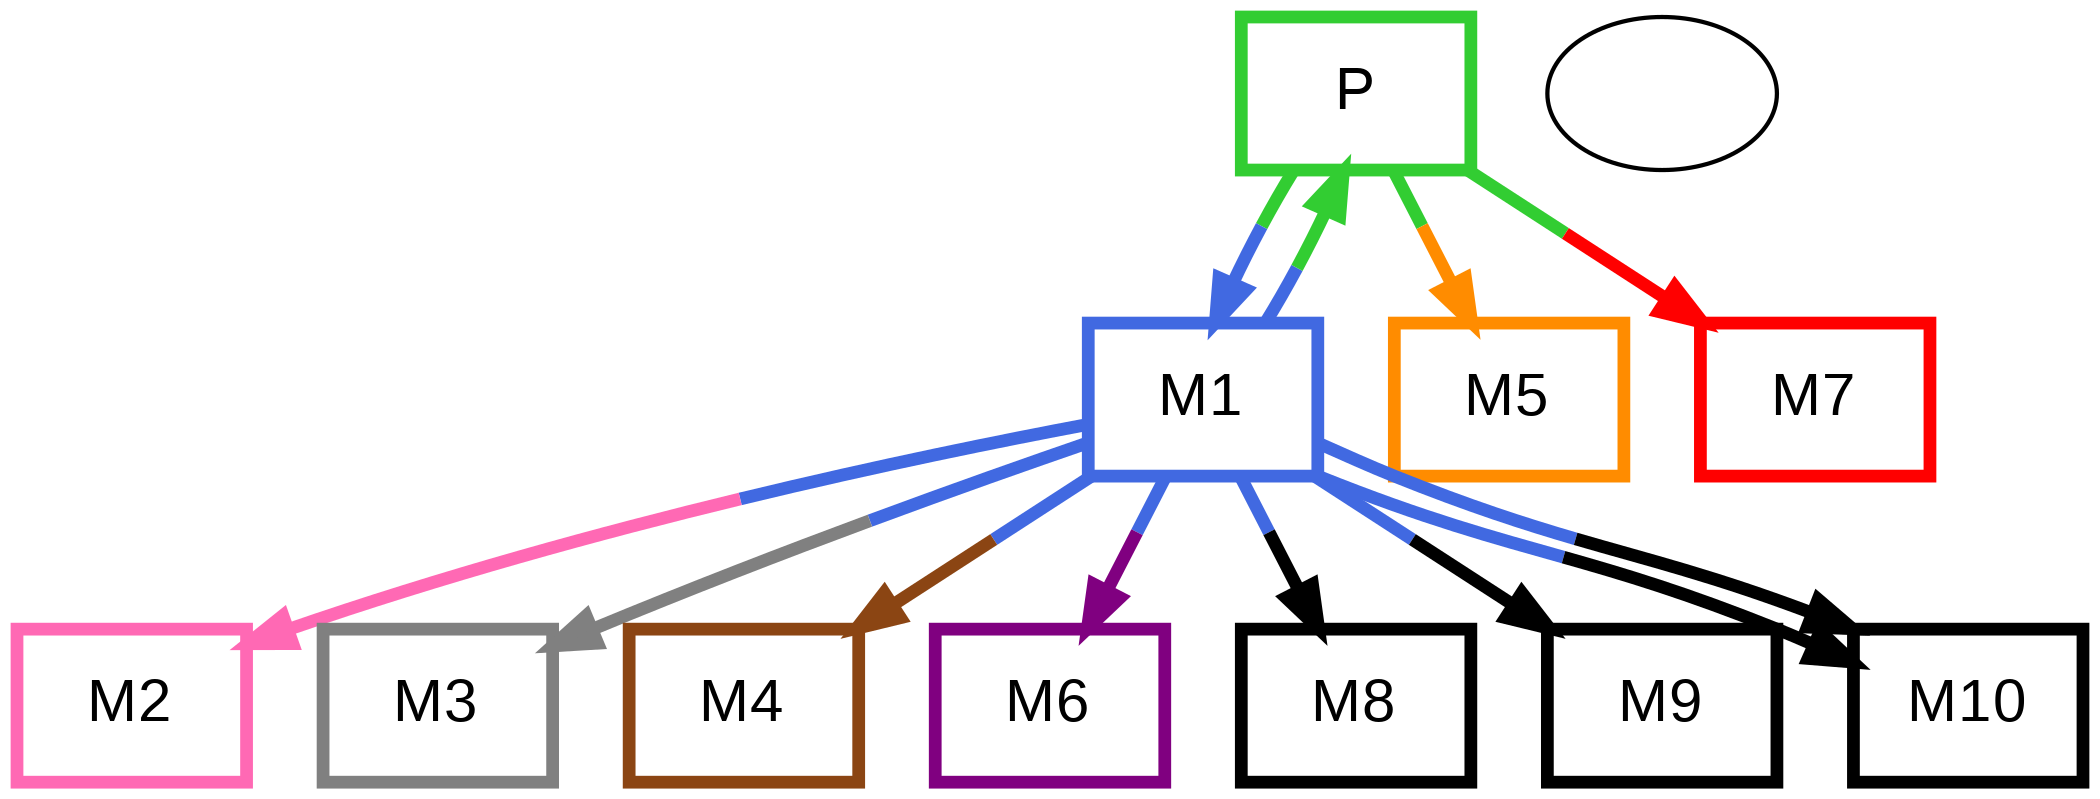

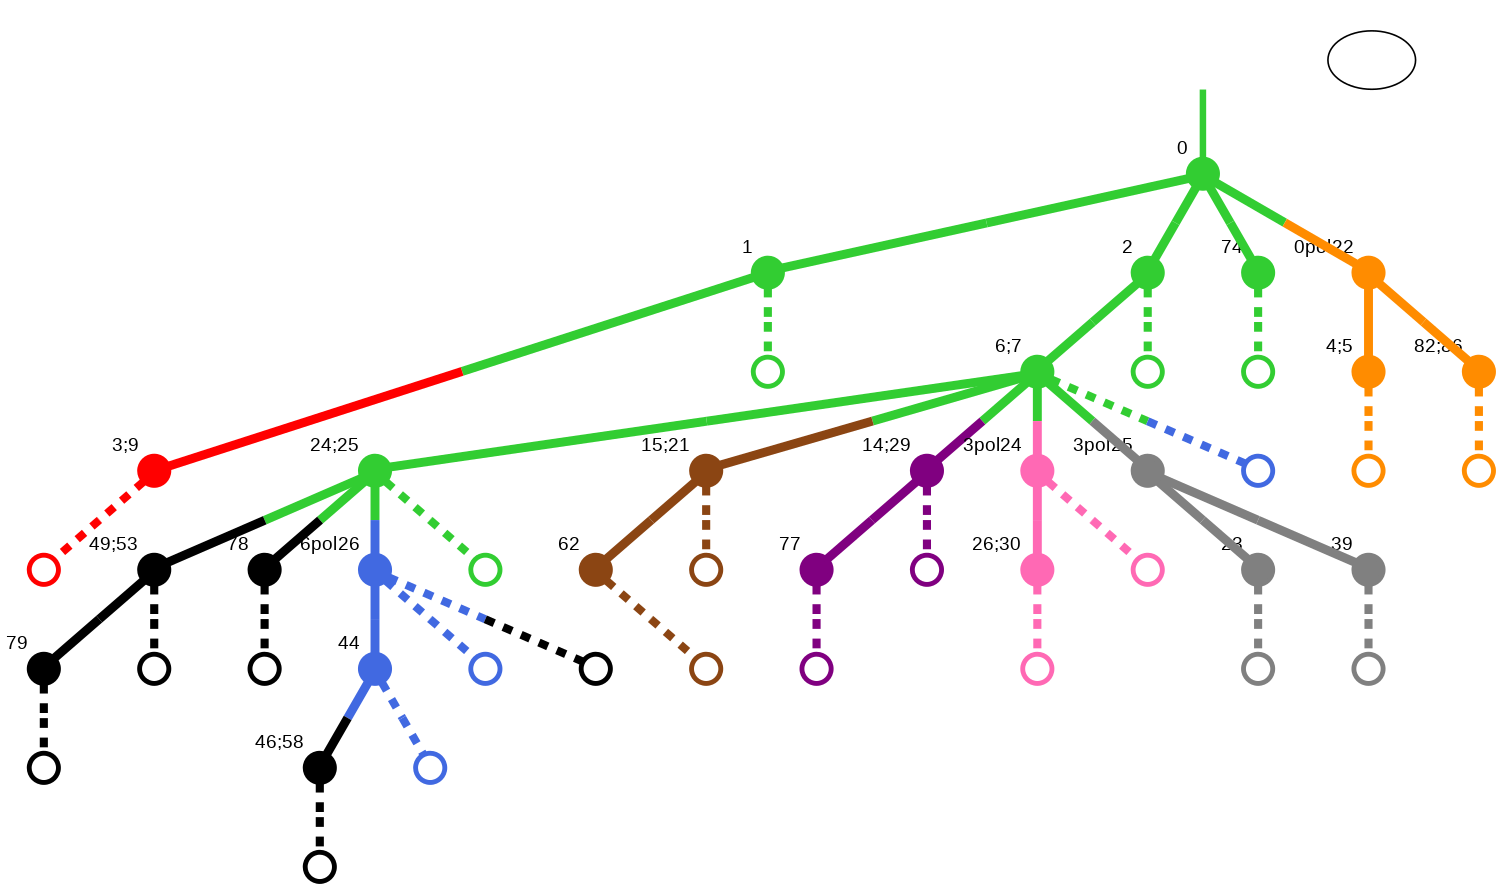

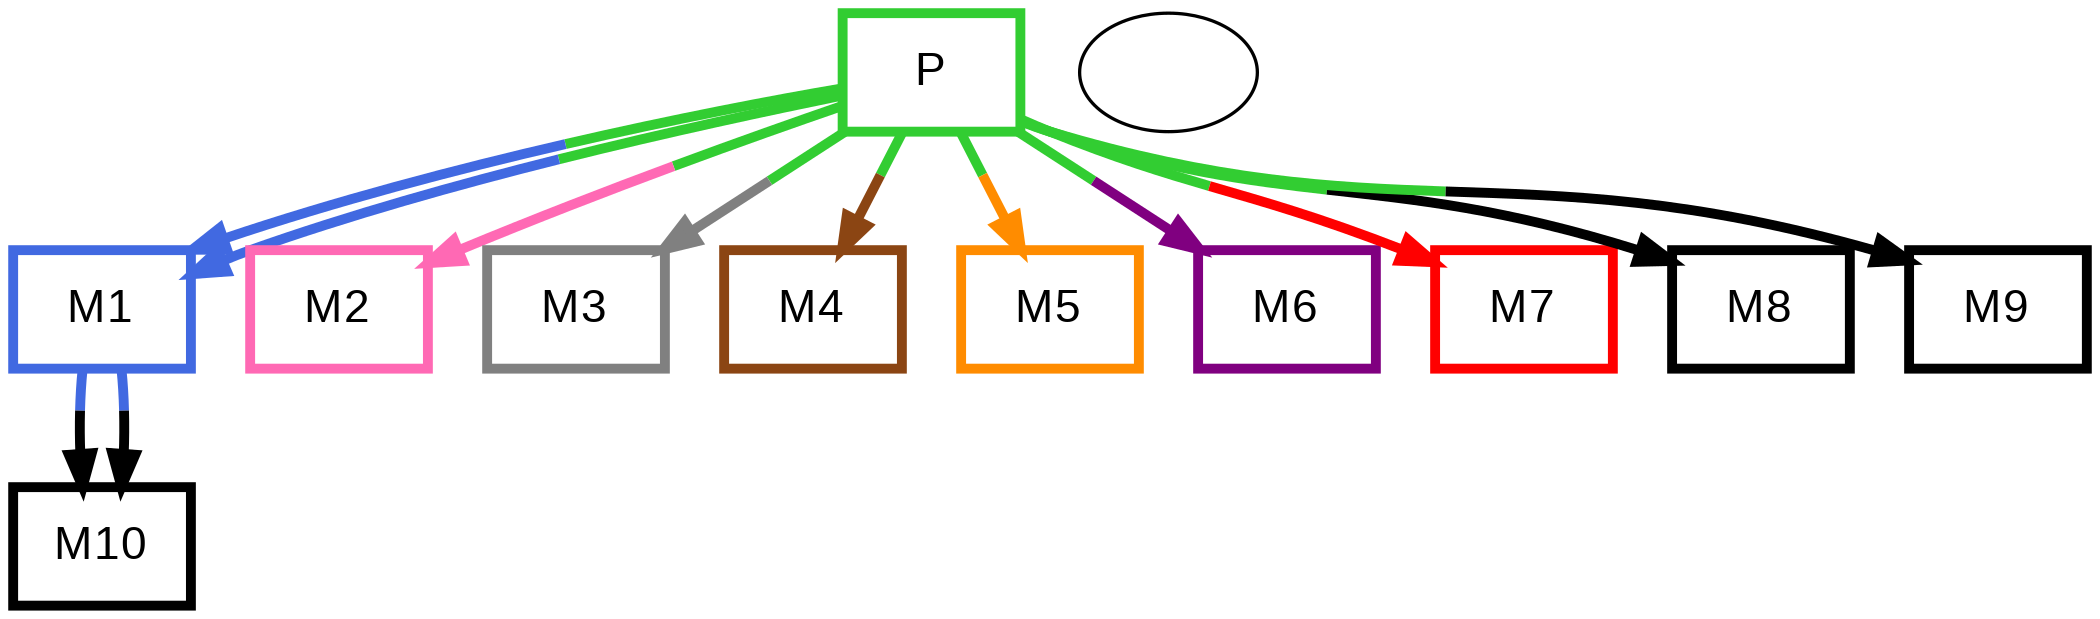

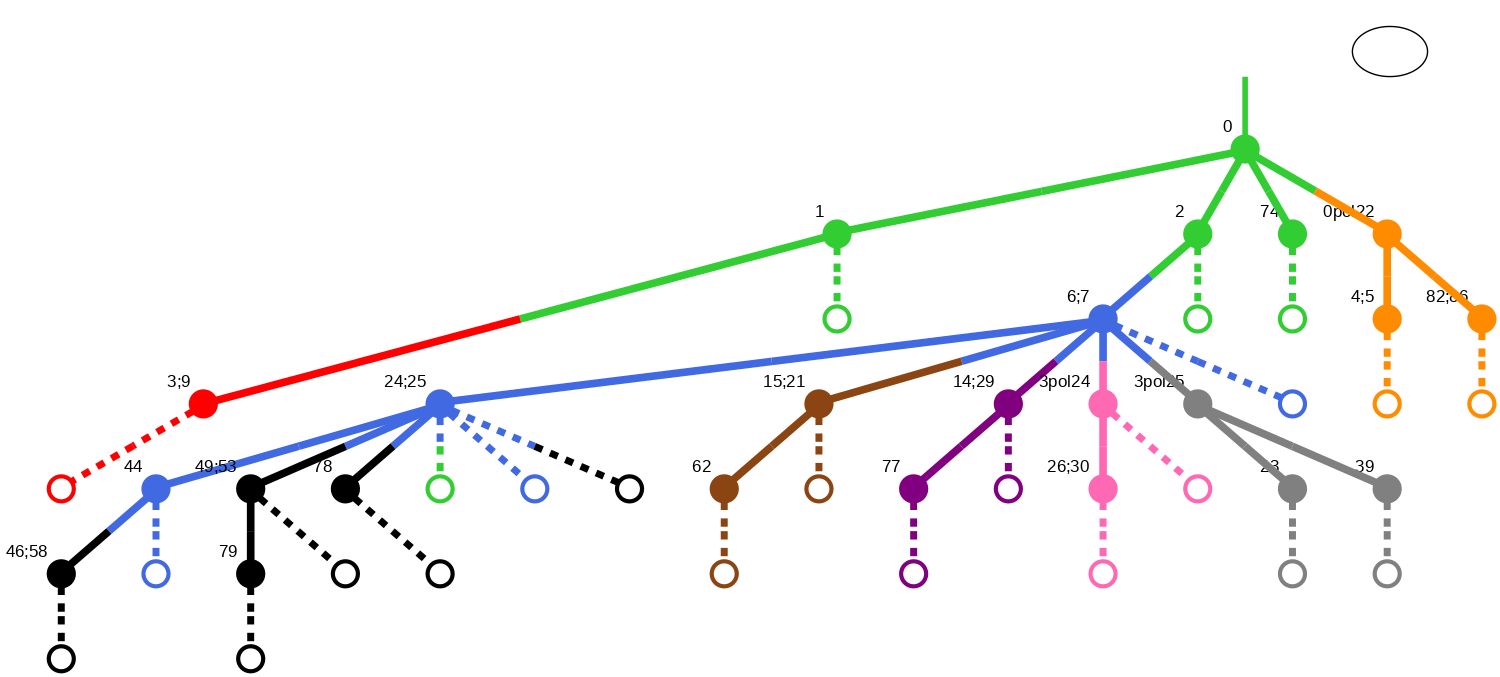

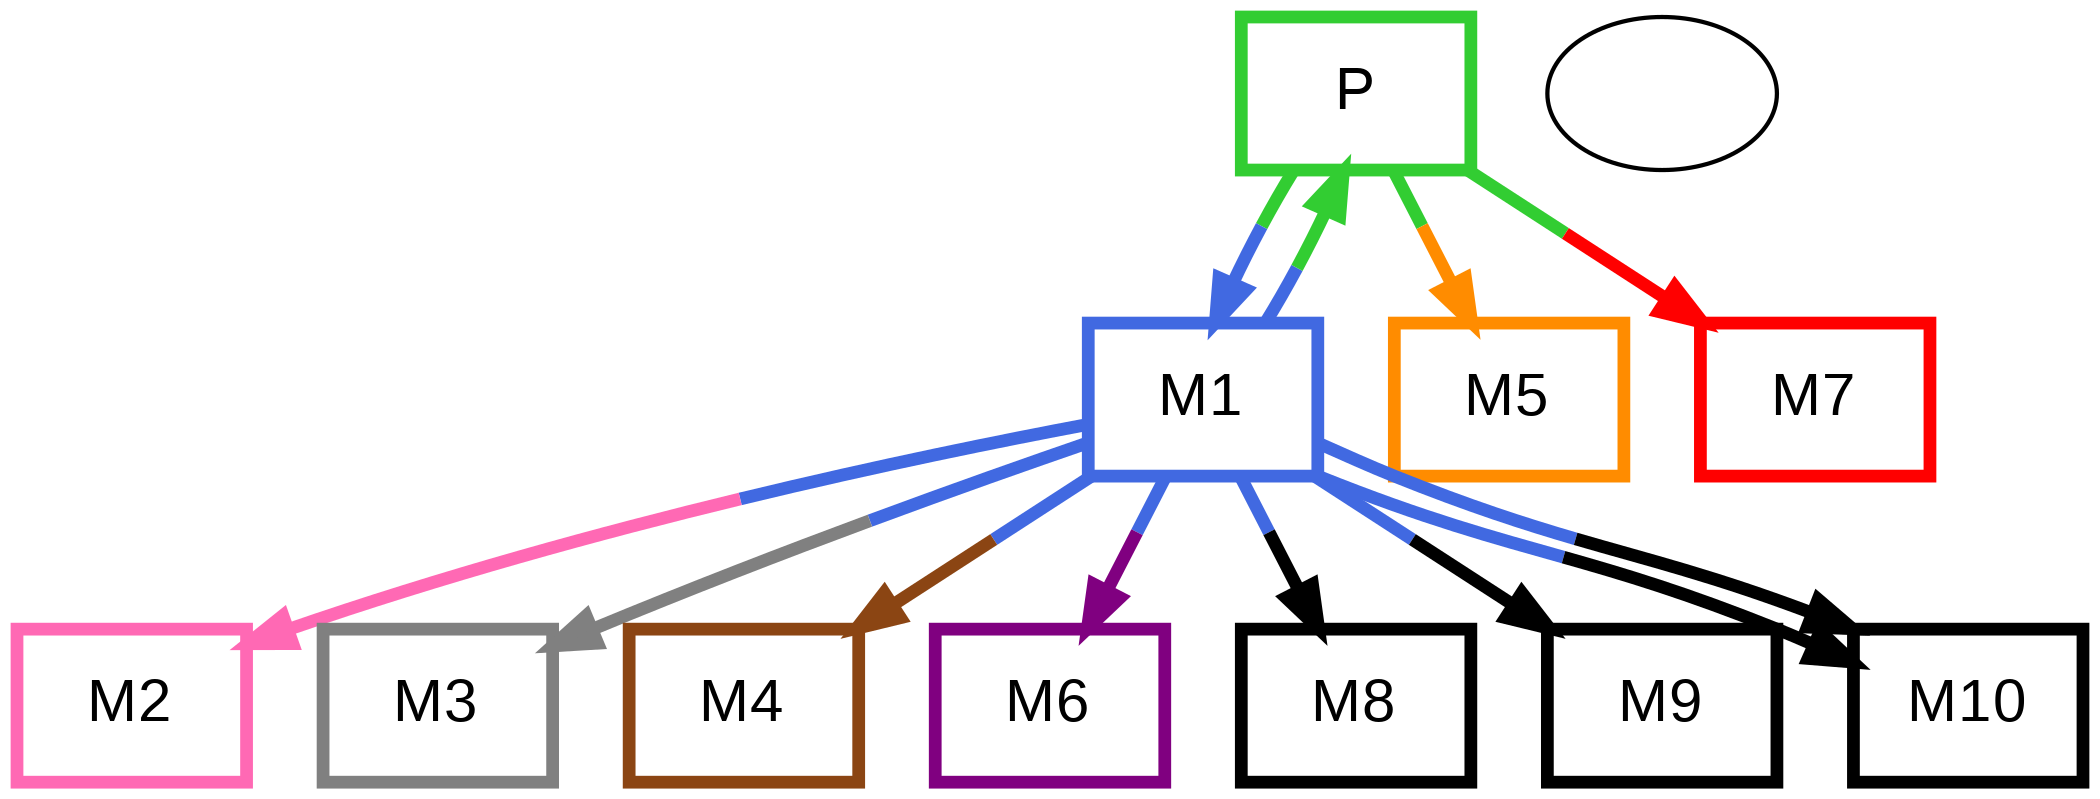

100%|██████████| 450/450 [00:26<00:00, 63.42it/s]

In [7]:
f = '/data/morrisq/divyak/data/metient_prediction_results/'

tree = 0

for run in range(5):
    base_fn = os.path.join(f, f"predictions_batch_exp_bs1024_calibrate_wip_solvepoly_r{run+1}_06202024", num_sites, mig_type)
    visualize_ground_truth(os.path.join(base_fn, f"tree{tree}_seed{seed}_calibrate.tree.dot"), os.path.join(base_fn, f"tree{tree}_seed{seed}_calibrate.mig_graph.dot"))
